In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import itertools as itertools
from tools import * 

In [2]:
# importing data 
df = pd.read_excel('./data/Superstore.xls')

In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Row ID,9994.0,4997.500000,2885.163629,1.000,2499.25000,4997.5000,7495.750,9994.000
Postal Code,9994.0,55190.379428,32063.693350,1040.000,23223.00000,56430.5000,90008.000,99301.000
Sales,9994.0,229.858001,623.245101,0.444,17.28000,54.4900,209.940,22638.480
Quantity,9994.0,3.789574,2.225110,1.000,2.00000,3.0000,5.000,14.000
Discount,9994.0,0.156203,0.206452,0.000,0.00000,0.2000,0.200,0.800
Profit,9994.0,28.656896,234.260108,-6599.978,1.72875,8.6665,29.364,8399.976


In [4]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [5]:
furniture = df[(df["Category"]=="Furniture")]
print (furniture["Order Date"].min(), furniture["Order Date"].max())

2014-01-06 00:00:00 2017-12-30 00:00:00


In [6]:
furniture.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Row ID,2121.0,5041.643564,2885.740258,1.0000,2568.000,5145.0000,7534.0000,9991.000
Postal Code,2121.0,55726.556341,32261.888225,1040.0000,22801.000,60505.0000,90032.0000,99301.000
Sales,2121.0,349.834887,503.179145,1.8920,47.040,182.2200,435.1680,4416.174
Quantity,2121.0,3.785007,2.251620,1.0000,2.000,3.0000,5.0000,14.000
Discount,2121.0,0.173923,0.181547,0.0000,0.000,0.2000,0.3000,0.700
Profit,2121.0,8.699327,136.049246,-1862.3124,-12.849,7.7748,33.7266,1013.127


In [7]:
# Removing columns that arent required/ wont be using this time
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name']
furniture = furniture.drop(cols,axis=1)
furniture.isnull().sum()

Order Date    0
Sales         0
Quantity      0
Discount      0
Profit        0
dtype: int64

In [8]:
furniture.columns

Index(['Order Date', 'Sales', 'Quantity', 'Discount', 'Profit'], dtype='object')

In [9]:
furniture = furniture.set_index('Order Date').sort_index()

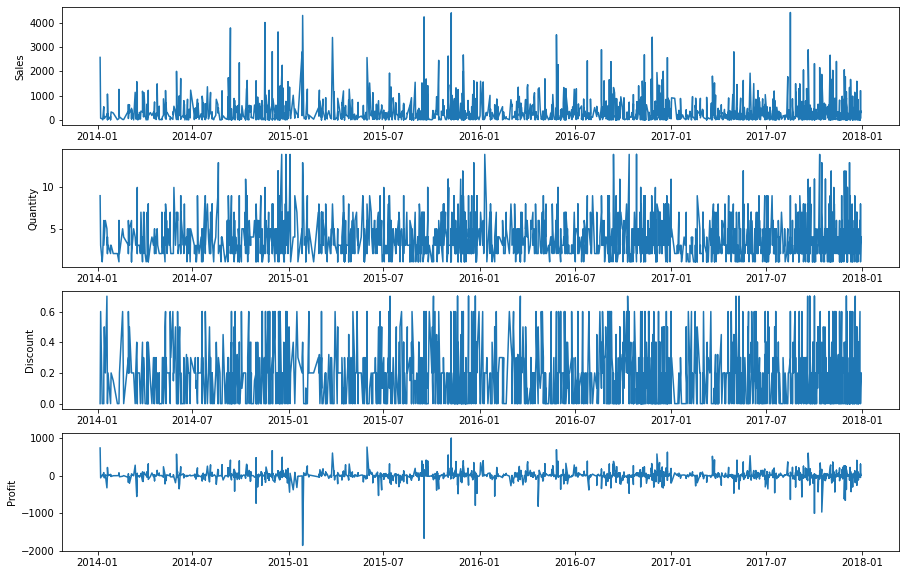

In [10]:
cols = furniture.columns
plt.figure(figsize=(15,10))
for i in range(0,len(cols)):
    plt.subplot(len(cols),1,i+1)
    plt.plot(furniture[cols[i]])
    plt.ylabel(cols[i])

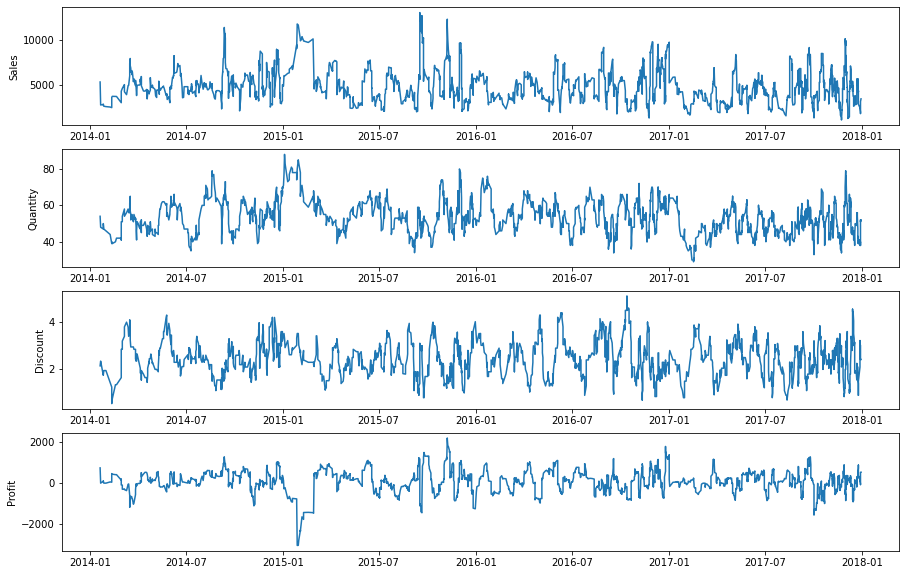

In [11]:
test = furniture.rolling(14).sum()
cols = furniture.columns
plt.figure(figsize=(15,10))
for i in range(0,len(cols)):
    plt.subplot(len(cols),1,i+1)
    plt.plot(test[cols[i]])
    plt.ylabel(cols[i])

In [12]:
# Using average daily sales per month instead of the daily sales 
furniture_monthly = furniture.resample('W').mean()
#Appling a 2 week smoothing filter over the data in order to keep all datapoints
furniture["Order Date"] = furniture.index
furniture = furniture.drop_duplicates(subset='Order Date')
furniture = furniture.drop('Order Date',axis=1)
furniture = furniture.asfreq('1D').interpolate(method='slinear')
furniture_smooth = furniture.ewm(span=7).mean()
furniture_smooth = furniture_smooth.sort_index()

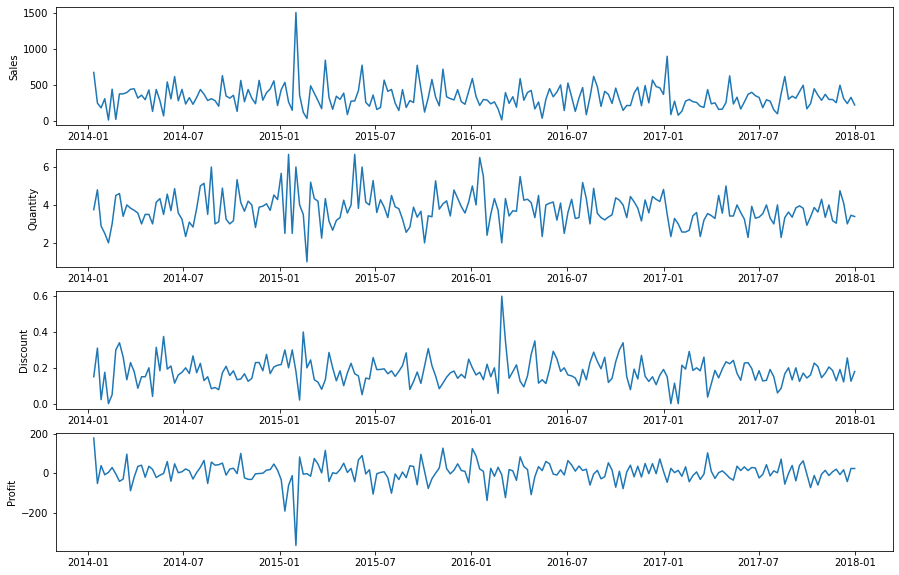

In [18]:
cols = furniture.columns
plt.figure(figsize=(15,10))
for i in range(0,len(cols)):
    plt.subplot(len(cols),1,i+1)
    plt.plot(furniture_monthly[cols[i]])
    plt.ylabel(cols[i])

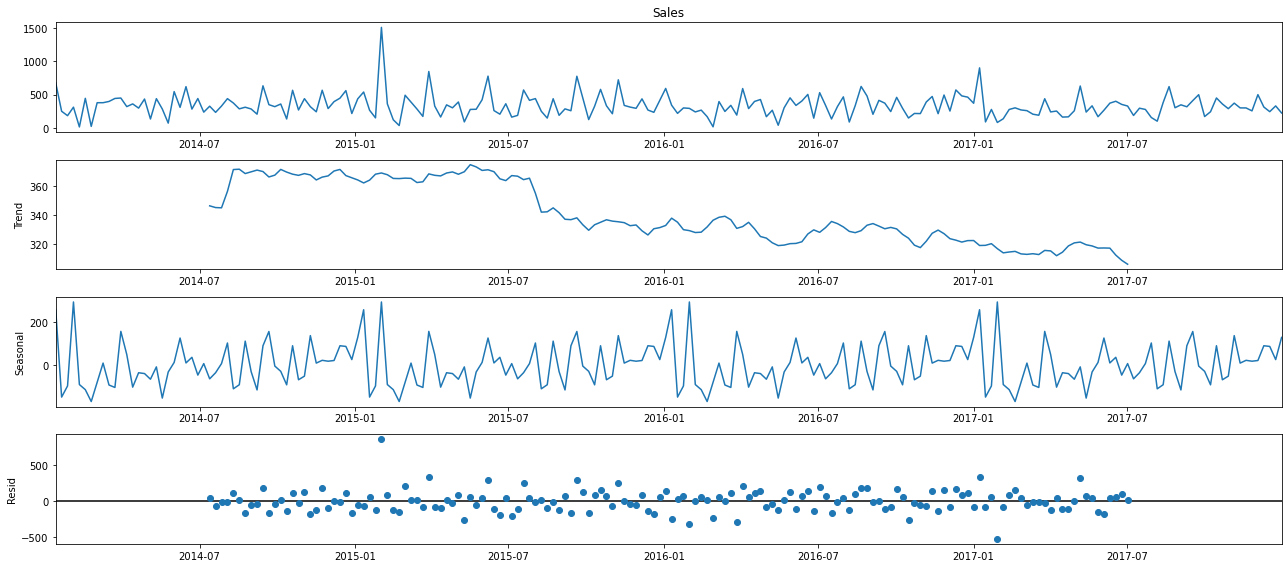

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(furniture_monthly["Sales"], period=52, model='additive')
decomposition.plot()
plt.show()

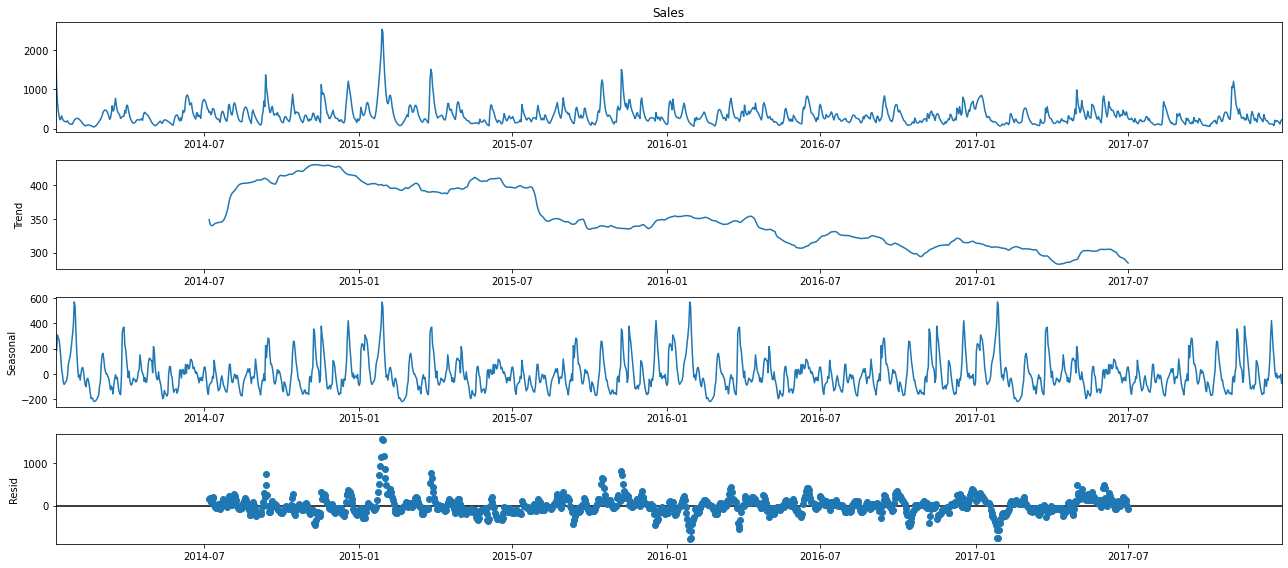

In [20]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(furniture_smooth["Sales"], period=365, model='additive')
decomposition.plot()
plt.show()

In [21]:
# Shows the various components of our time series

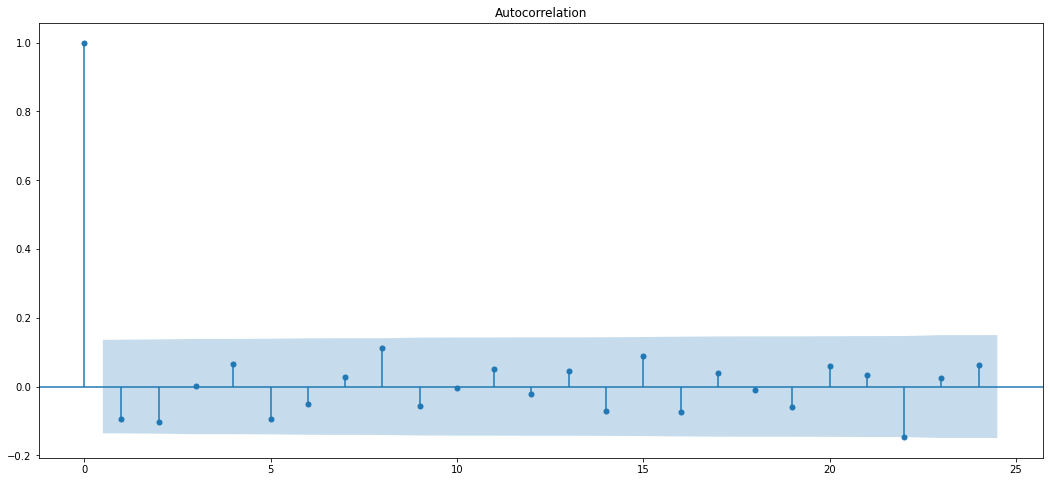

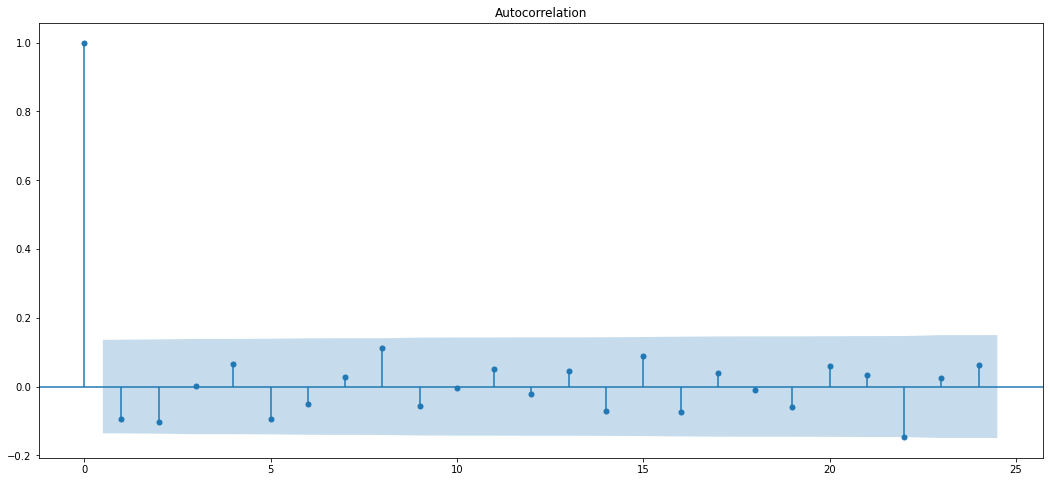

In [22]:
plot_acf(furniture_monthly["Sales"])

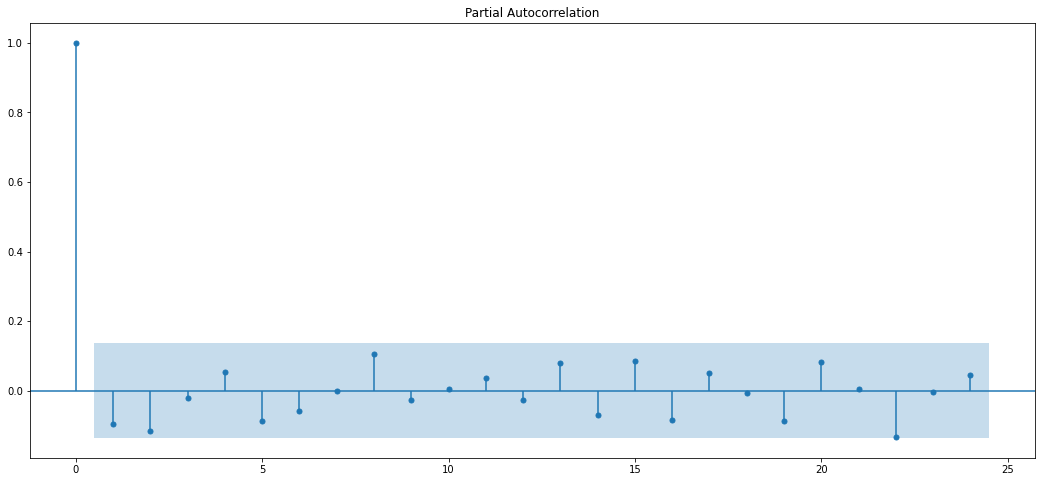

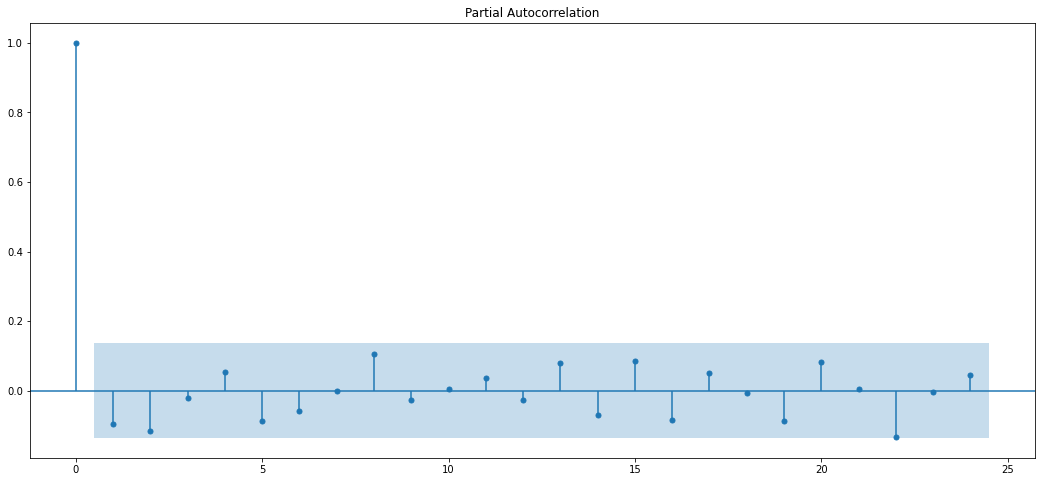

In [23]:
plot_pacf(furniture_monthly["Sales"])

In [24]:
def split_dataset(data,split=0.8):
    train = data[0:round(len(data)*split)]
    test = data[round(len(data)*(split))-1::]
    print ("%s datapoints in training set" %(len(train)))
    print ("%s datapoints in test set" %(len(test)))

    return train, test

In [25]:
def make_params(rng=2):
    # Looping over the possible range of parameters
    p = d = q = range(0, rng)
    params = list(itertools.product(p, d, q))
    # Adding in 12 to include 12 months seasonality
    seasonal_params = [(x[0], x[1], x[2], 52) for x in params]

    return params, seasonal_params

In [26]:
def grid_search(data, params, seasonal_params, verbose=False):

    # Looping over all parameter combinations and training a SARIMAX model
    log = {}
    for param in params: 
        for seasonal_param in seasonal_params: 

            model = SARIMAX(data,
                            order=param,
                            seasonal_order=seasonal_param,
                            enforce_stationarity=False, 
                            enforce_invertibility=False)

            results = model.fit()

            log["%s,%s"%(param,seasonal_param)] = results.aic
            if verbose: 
                print ("Param : %s, %s        AIC: %.3f" %(param, seasonal_param,results.aic))
            
        # Sorting items in the log to see the best parameter combination 
        best_params = sorted(log.items(), key=lambda x: x[1])
        # Best combinations 
        print ("Best parameter combination = "+str(best_params[0][0]))
        print ("AIC score = "+str(best_params[0][1]))
        
        return log, results, best_params

In [27]:
# Splitting data
train, test = split_dataset(furniture_monthly)
# Making param grid for search 
params, seasonal_params = make_params()
# grid searching for best params
log, results,best_params = grid_search(train["Sales"],params,seasonal_params)

166 datapoints in training set
43 datapoints in test set
/Users/Graham/opt/anaconda3/envs/Py3_7TensorFlow/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/Graham/opt/anaconda3/envs/Py3_7TensorFlow/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
Best parameter combination = (0, 0, 0),(0, 1, 1, 52)
AIC score = 832.0231395008503


In [28]:
# Fitting data with best model 
model = SARIMAX(train["Sales"],
                order=(0,0,0),
                seasonal_order=(0,1,1,52),
                enforce_invertibility=False)
results = model.fit()

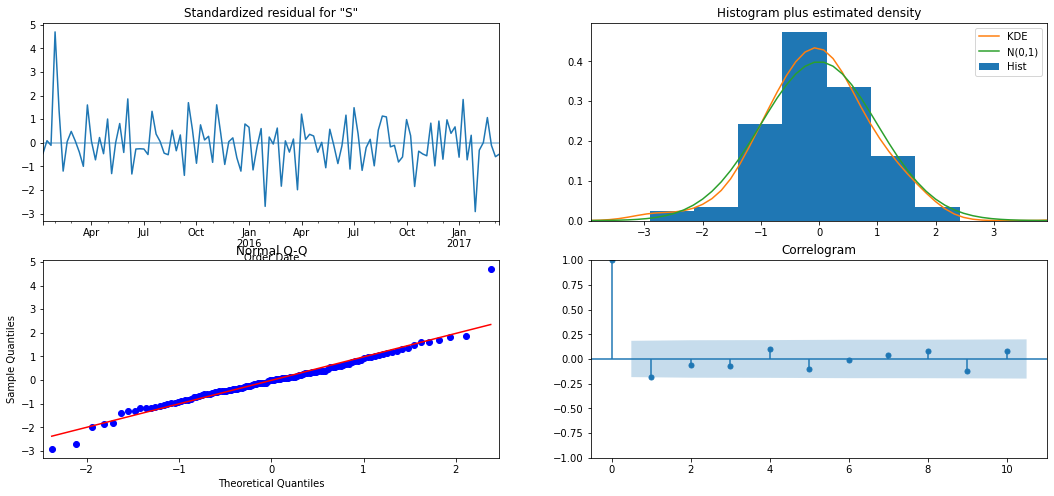

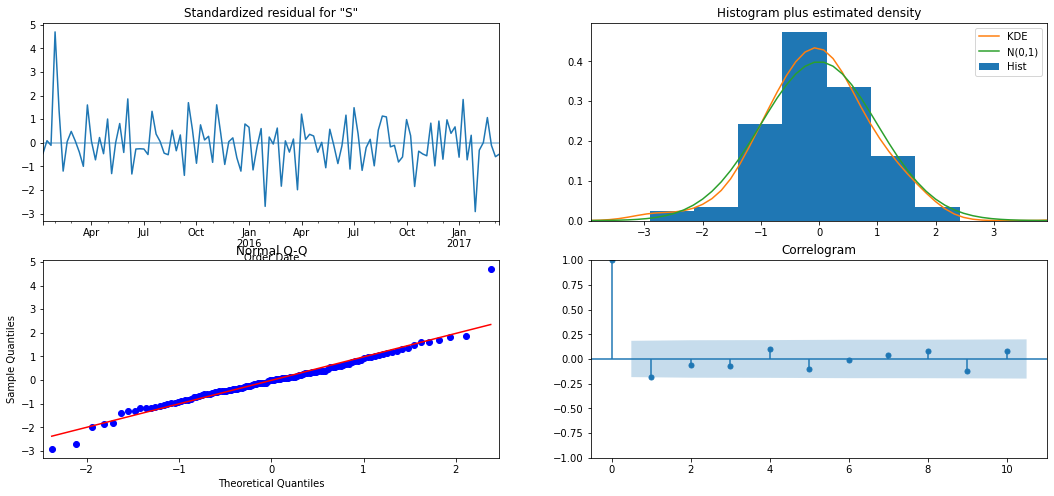

In [29]:
results.plot_diagnostics()

In [30]:
# Predictions 
pred = results.get_prediction(start=len(train)-1, end=len(train)+len(test)-2,dynamic=False)
pred_conf = pred.conf_int(alpha=0.4)
ARIMA_pred = np.array(pred.predicted_mean)

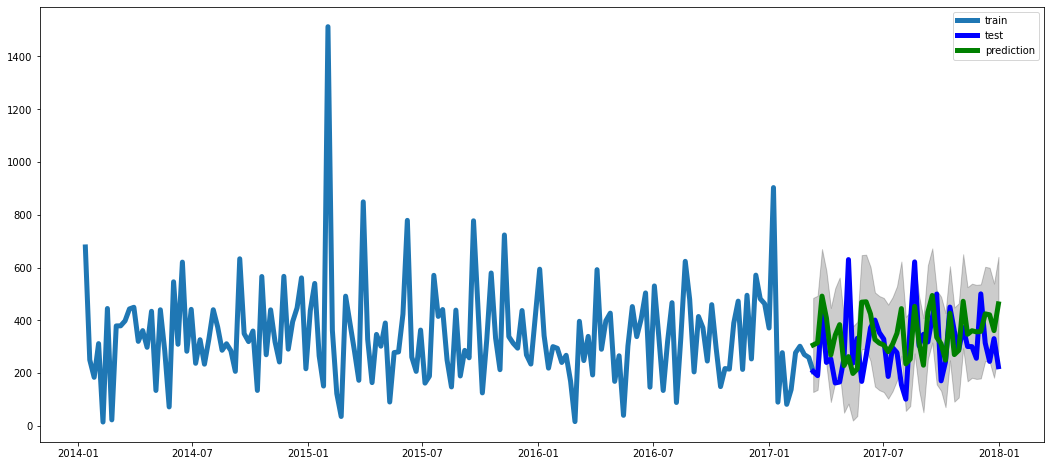

In [32]:
plt.plot(train["Sales"],linewidth=5,label='train')
plt.plot(test["Sales"],'b',linewidth=5,label='test')
plt.plot(test.index,ARIMA_pred,'g',linewidth=5,label='prediction')
plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.2)
plt.legend()

In [295]:
def evaluate_forecasts(actual, predicted):
    mse = (actual-predicted)**2
    rmse= np.sqrt(mse)
    score = np.sqrt((np.sum(mse)/len(actual)))
    return rmse, score

In [34]:
def plot_results(actual, predicted):
    rmse, score = evaluate_forecasts(actual,predicted)
    plt.subplot(2,1,1)
    plt.plot(actual,marker='o',label='actual')
    plt.plot(actual.index,predicted,marker='o',label='predicted')
    plt.legend()
    plt.title("Actual Vs Predicted")
    plt.subplot(2,1,2)
    plt.plot(actual.index,rmse,marker='o',label='rmse')
    plt.title('RMSE per prediction. Overall RMSE = %.2f'%score)

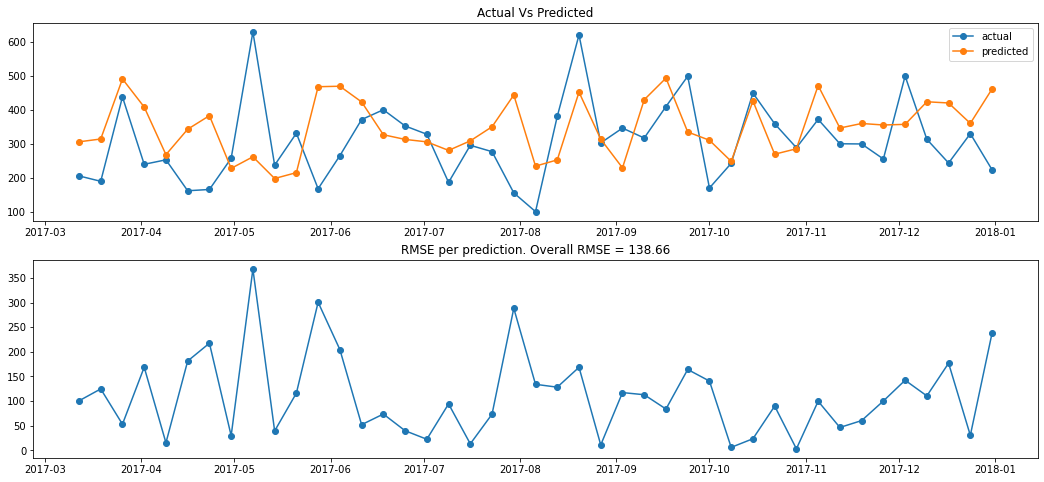

In [35]:
plot_results(test["Sales"],ARIMA_pred)

In [217]:
scores = {}
_,rmse = evaluate_forecasts(test["Sales"],ARIMA_pred)
scores["ARIMA"] = rmse

IndexError: index 43 is out of bounds for axis 0 with size 43